In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import json
import glob as glob
import os
%matplotlib inline

In [2]:
def to_seconds(timestamp):
    ts = timestamp.split(':')
    return float(float(ts[0])*60*60 + float(ts[1])*60 + float(ts[2]))

def parse_mdtest(files):
    r = []
    for fname in sorted(files):
        with open(fname) as f:
            data = json.load(f)
            for line in data['stdout_lines']:
                if "started" in line: start = line.split()[4]
                if "finished" in line: end = line.split()[4]
            r.append(to_seconds(end) - to_seconds(start))
    return r

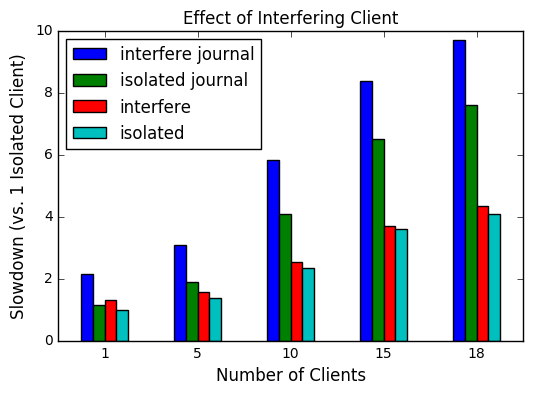

In [40]:
norm = np.mean(parse_mdtest(glob.glob("../results-cloudlab-clients1-nolog/*isolated*")))

mean = pd.DataFrame(columns=["interfere journal", "isolated journal", "interfere", "isolated"])
stds = pd.DataFrame(columns=["interfere journal", "isolated journal", "interfere", "isolated"])
clients = [1, 5, 10, 15, 18]
for i in clients:
    j0 = parse_mdtest(glob.glob("../results-cloudlab-clients" + str(i) + "/*interfere*"))
    j1 = parse_mdtest(glob.glob("../results-cloudlab-clients" + str(i) + "/*isolated*"))    
    j2 = parse_mdtest(glob.glob("../results-cloudlab-clients" + str(i) + "-nolog/*interfere*"))
    j3 = parse_mdtest(glob.glob("../results-cloudlab-clients" + str(i) + "-nolog/*isolated*"))    
    mean.loc[len(mean)] = [np.max(j0/norm), np.max(j1/norm), np.max(j2/norm), np.max(j3/norm)]
    stds.loc[len(stds)] = [np.std(j0/norm), np.std(j1/norm), np.std(j2/norm), np.std(j3/norm)]    
fig, ax = plt.subplots(1, 1)
mean.plot.bar(ax=ax)
ax.set_ylabel("Slowdown (vs. 1 Isolated Client)", fontsize=12)
ax.set_title("Effect of Interfering Client", fontsize=12)
ax.set_xlabel("Number of Clients", fontsize=12)
x = ax.set_xticklabels(clients, rotation=0)
fig.savefig('graphs/slowdown-interfere-scale.png', bbox_inches='tight', dpi=400)